In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
from astropy.io import fits, ascii
from astropy.table import Table
import os
import math

import TheCannon
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2016/bin/x86_64-darwin'

In [2]:
dfile = AP_PATH + '/training_sets/mann_sample/'
rfile = 'train_ref/mann_ref_labels.csv'  
tr_label = ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H'])
tr_label_unc = ap.loadLabels(rfile, lbl_names=['E_TEFF', 'E_FE_H'])
ds = ap.initializeTrainingSet(data=dfile, ref=rfile, lbl_names=['TEFF', 'FE_H'], save_base='mann')

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/training_sets/mann_sample/
Spectra loaded
Loading dataset
This may take a while...
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/mann_norm_tr_flux.npy
Loaded /home/jess/Desktop/Research/apogee_data/training_sets/norm_fluxes/mann_norm_tr_ivar.npy


In [3]:
md, synth_fluxes, test_labels = ap.runCannon(ds)

Done training model. 
Inferring Labels


In [5]:
ds.diagnostics_1to1()

Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png


In [5]:
trn_labels, crv_labels = ap.crossValidate(ds, lbl_names=['TEFF', 'FE_H'])

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [0/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [1/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [2/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [3/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [4/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [5/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [6/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [7/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [8/30] sources.

Loading dataset
Done training model. 
Inferring Labels
Inferring Labels
Labeled [9/30] sources.

Loading dataset
Done training 

In [10]:
np.save('mann_results/trn_labels.npy', trn_labels)
np.save('mann_results/crv_labels.npy', crv_labels)

In [2]:
trn_labels = np.load('mann_results/trn_labels.npy')
crv_labels = np.load('mann_results/crv_labels.npy')

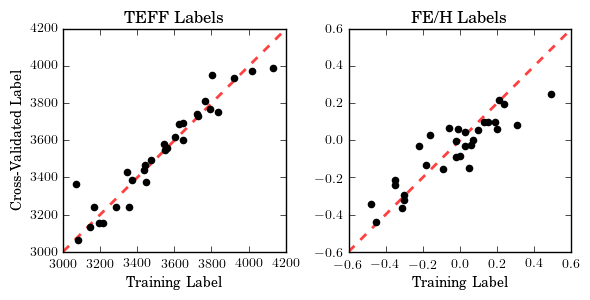

In [7]:
ap.plotCrossValidation(trn_labels, crv_labels, save=True, label_names=['TEFF', 'FE/H'], out='mann_results/mann_cross_validation.pdf')

In [132]:
def plotCannonModels(ds, te_flux, te_labels, **kwargs):

    nspecs = len(te_flux)
    bands  = [[15160,15800],[15880,16420],[16500,16935]]
    n      = kwargs.get('band', 1)
    yrange = kwargs.get('yrange', [.6,1.2])
    lbl_names = kwargs.get('lbl_names', ['TEFF', 'FE/H'])
    snr = kwargs.get('snr', [])
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Models_Band'+str(n)+'.pdf')
    
    tr_label = ds.tr_label
    tr_label_unc = kwargs.get('tr_lbl_unc')
    te_label = te_labels
    te_label_unc = kwargs.get('te_lbl_unc', [0,0])
    
    wl = ds.wl
    tr_flux = ds.tr_flux
    tr_ivar = ds.tr_ivar
    
    fig, axs = plt.subplots(nspecs, 1, figsize=(12,3*nspecs))
    for i, ax in enumerate(fig.axes):

        tr_stdev = [1/math.sqrt(ivar) for ivar in tr_ivar[i]]
    
        data = ap.Spectrum(wave=wl, flux=tr_flux[i], sigmas=tr_stdev)
        mdl  = ap.Spectrum(wave=wl, flux=te_flux[i])
        chi  = ap.compareSpectra(data, mdl, fit_scale=False)[0]
        
        ax.plot(wl, tr_flux[i], color='k')
        ax.plot(wl, te_flux[i], color='r')
        
        cannon_lbl = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(te_label[i][0],-1), te_label_unc[0], round(te_label[i][1],2), te_label_unc[1]) 
        ax.text(bands[n-1][0]+10, yrange[1]-.08, cannon_lbl,color='r', fontsize=15, va='bottom', ha='left')
        
        ref_lbl = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(tr_label[i][0],-1), tr_label_unc[i][0], round(tr_label[i][1],2), tr_label_unc[i][1]) 
        ax.text(bands[n-1][0]+10, yrange[0]+.08, ref_lbl, color='k', fontsize=15, va='top', ha='left')
        
        chi_lbl = r'$\chi^{2} = %s$'%(str(chi))
        ax.text(bands[n-1][1]-10, yrange[1]-.08, chi_lbl, color='r', fontsize=15, va='bottom', ha='right')
        
        if len(snr) != 0:
            snr_lbl = r'$SNR = {}$'.format(str(snr[i]))
            ax.text(bands[n-1][1]-10, yrange[0]+.08, snr_lbl, color='k', fontsize=15, va='top', ha='right')
         
        ax.set_title(r'${}$'.format(ds.tr_ID[i]), fontsize=20)
        ax.set_xlim(bands[n-1])
        ax.set_ylim(yrange)
        ax.set_ylabel(r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', fontsize=15)
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=15)
    
    plt.tight_layout()
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()

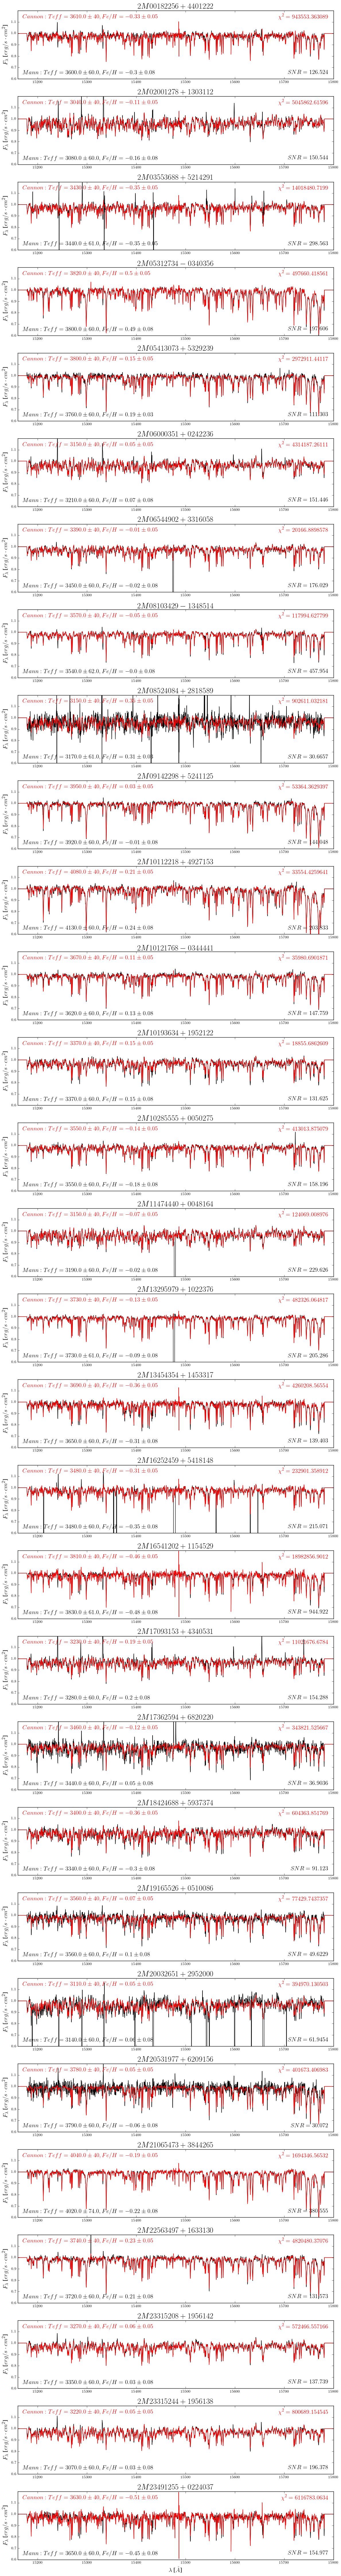

In [50]:
n = 1
snr = pd.read_csv(rfile)['SNR']
plotCannonModels(ds, synth_fluxes, test_labels, save=True, out='mann_results/Models_Band'+str(n)+'.pdf', \
                 tr_lbl_unc=tr_label_unc, te_lbl_unc=[40,.05], snr=snr, band=n)

In [21]:
def plotModelSet(wl, tr_flux, te_flux, tr_label, te_label, tr_unc, te_unc, tr_ID, **kwargs):

    nspecs = len(te_flux)
    bands  = [15160,16935]
    regs   = [[15650,15780], [16150,16280]]
    yrange = kwargs.get('yrange', [.61,1.2])
    lbl_names = kwargs.get('lbl_names', ['TEFF', 'FE/H'])
    
    save = kwargs.get('save', False)
    out  = kwargs.get('out', 'Model_Demo.pdf')
    
    fig, axs = plt.subplots(nspecs, 1, figsize=(20,2.5*nspecs), facecolor='w', sharex=True, sharey=True)
    for i, ax in enumerate(fig.axes):
        
        tr_flux[i] = np.array(tr_flux[i])
        tr_flux[i][tr_flux[i] > np.mean(tr_flux[i]) + 3*np.std(tr_flux[i])] = np.nan
        
        ax.plot(wl, tr_flux[i], color='k', linewidth=1)
        ax.plot(wl, te_flux[i], color='r', linewidth=1)
        ax.axvspan(regs[0][0], regs[0][1], color='b', alpha=0.07)
        ax.axvspan(regs[1][0], regs[1][1], color='b', alpha=0.07)
        ax.text(bands[1]+15, .9, tr_ID[i], ha='center', va='center', rotation=270, fontsize=10)
        
        cannon_lbl = r'$Cannon: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(te_label[i][0],-1), te_unc[0], round(te_label[i][1],2), te_unc[1]) 
        ax.text(bands[0]+15, yrange[1]-.1, cannon_lbl,color='r', fontsize=15, va='bottom', ha='left')

        ref_lbl = r'$Mann: Teff = {} \pm {}, Fe/H = {} \pm {}$'.format(round(tr_label[i][0],-1), tr_unc[i][0], round(tr_label[i][1],2), tr_unc[i][1]) 
        ax.text(bands[1]-15, yrange[1]-.1, ref_lbl, color='k', fontsize=15, va='bottom', ha='right')
        
        ax.set_xlim(bands)
        ax.set_ylim(yrange)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        if i == nspecs-1:
            ax.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
    
    fig.subplots_adjust(hspace=0)
    fig.text(.1, .5, r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', ha='center', va='center', rotation='vertical', fontsize=20)
    if save == True:
        plt.savefig(str(out))
    plt.show()
    plt.close()

In [22]:
demo_specs = ['2M02001278+1303112', '2M21065473+3844265', '2M16541202+1154529', '2M05312734-0340356']
id_list = pd.read_csv(rfile)['ID']
demo_indices = [np.where(np.array(id_list) == name)[0][0] for name in demo_specs]
    
demo_tr_flux = [ds.tr_flux[i] for i in demo_indices]
demo_te_flux = [synth_fluxes[i] for i in demo_indices]

demo_tr_unc = [tr_label_unc[i] for i in demo_indices]
demo_te_unc = [40,.05]

demo_tr_label = [ds.tr_label[i] for i in demo_indices]
demo_te_label = [test_labels[i] for i in demo_indices]

# tr_specs = [ap.Spectrum(wave=ds.wl, flux=demo_tr_flux[i], name=demo_specs[i])]

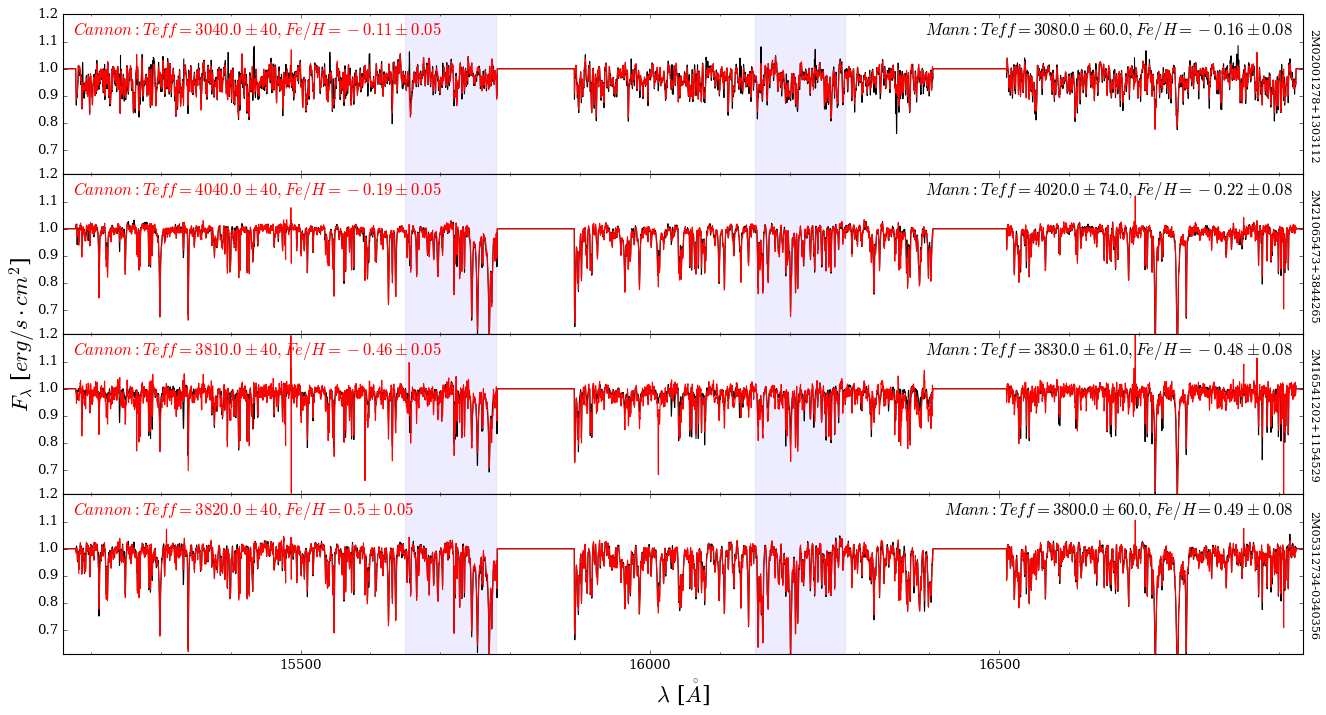

In [23]:
plotModelSet(ds.wl, demo_tr_flux, demo_te_flux, demo_tr_label, demo_te_label, demo_tr_unc, demo_te_unc, \
            demo_specs, save=True, out='0_mann_results/Model_Demo.png')

In [16]:
def plotMultiSpec(wl, tr_flux, te_flux, tr_label, te_label, tr_unc, te_unc, tr_ID, **kwargs):

    yrange = kwargs.get('yrange', [.61, 1.2])
    regs   = kwargs.get('regs', [[15650,15780], [16150,16280]])
    save   = kwargs.get('save', False)
    out    = kwargs.get('out', 'Cannon_Regions.pdf')
    
    xdim, ydim = [len(regs), len(tr_flux)]
    nplots = xdim*ydim
    nspecs = len(tr_flux)
    
    fig, ax = plt.subplots(ydim, xdim, sharey=True, sharex=True, figsize=(16, ydim*2.5), facecolor='w')
    ax = ax.ravel()
    
    for j in range(nspecs):
        i = 2*j+1
        ax[j] = fig.add_subplot(ydim,xdim,i)                                                                   
        ax[j].plot(wl, tr_flux[j], color='k', linewidth=1)
        ax[j].plot(wl, te_flux[j], color='r', linewidth=1)
        ax[j].set_xlim(regs[0])
        ax[j].set_ylim(yrange)
        ax[j].xaxis.set_minor_locator(AutoMinorLocator(5))
        ax[j].yaxis.set_major_formatter(plt.NullFormatter())
        
        ax[j+1] = fig.add_subplot(ydim,xdim,i+1)                                                                   
        ax[j+1].plot(wl, tr_flux[j], color='k', linewidth=1)
        ax[j+1].plot(wl, te_flux[j], color='r', linewidth=1)
        ax[j+1].set_xlim(regs[1])
        ax[j+1].set_ylim(yrange)
        ax[j+1].xaxis.set_minor_locator(AutoMinorLocator(5))
        ax[j+1].yaxis.set_major_formatter(plt.NullFormatter())
        
        if j == nspecs-1:   
            ax[j].set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
            ax[j+1].set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)

    fig.subplots_adjust(hspace=0, wspace=.05)
#     plt.setp([a.get_yticklabels() for a in fig.axes[1::2]], visible=False)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)
    fig.text(.09, .5, r'$F_{\lambda}$ [$erg/s \cdot cm^{2}$]', ha='center', va='center', rotation='vertical', fontsize=20)
    
    if save == True:
        plt.savefig(str(out))
        
    plt.show()
    plt.close()

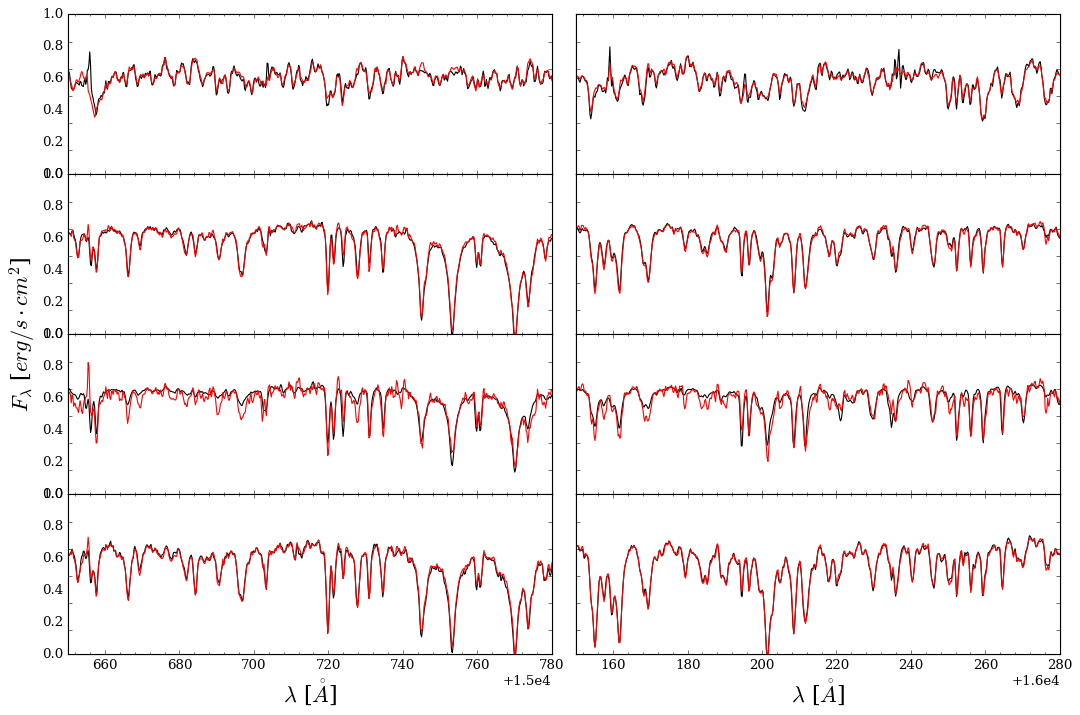

In [20]:
plotMultiSpec(ds.wl, demo_tr_flux, demo_te_flux, demo_tr_label, demo_te_label, demo_tr_unc, demo_te_unc, \
            demo_specs, save=True, out='0_mann_results/Ness_Regions.png')

In [13]:
np.mean(demo_tr_flux[1])

0.97180762902173146